In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import USPS

import matplotlib.pyplot as plt
import numpy as np

from source.models import AE
from source.data import get_train_test_dataloaders
from source.eval import eval_loss

from functools import partial
import copy
from tqdm import tqdm
from multiprocessing import Pool

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/daria.cherniuk/.conda/eve3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_progress(x, z):
    rows = 4
    cols = 16
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(cols, rows))
    for i in range(len(x)):
        ax[i//cols, i%cols].imshow(x[i].cpu().reshape([16, 16]), 'gray')
        ax[i//cols, i%cols].set_axis_off()
    for i in range(len(z)):
        ax[i//cols+2, i%cols].imshow(z[i].detach().cpu().numpy().reshape([16, 16]), 'gray')
        ax[i//cols+2, i%cols].set_axis_off()
    plt.show()

In [4]:
train_loader, test_loader = get_train_test_dataloaders('..', 'USPS', batch_size=7291, drop_last=False)
len(train_loader), len(test_loader)

6580224it [00:02, 2777520.47it/s]                             


1831936it [00:01, 987442.70it/s]                              


(1, 1)

In [5]:
model = AE().to(device)
loss_function = torch.nn.MSELoss()
print('Random-initialized model loss: '
      f'{eval_loss(model, test_loader, loss_function, device=device)}')

Random-initialized model loss:0.1619708240032196


Random-initialized model reconstruction results:


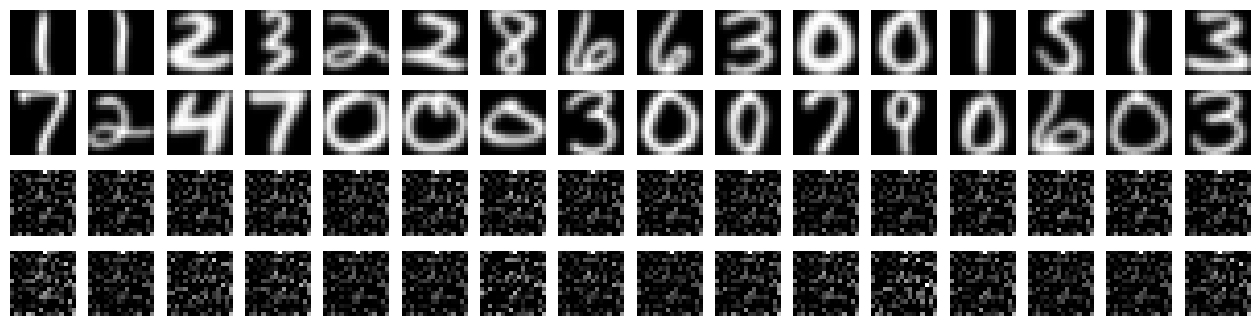

In [6]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [7]:
CACHE_OUTPUTS = {}
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()
    
def cache_output_hook(idx, module, input, output):
    CACHE_OUTPUTS[idx] = output.detach().cpu()

i, j = 0 , 0
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
    elif isinstance(m, nn.Linear):
        handle = m.register_forward_hook(partial(cache_output_hook, j))
        j += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.cpu()
        
# sized of cached activattions
for i in range(len(CACHE_RELUS)):
    # print(CACHE_OUTPUTS[i].shape)
    print(CACHE_RELUS[i].shape)

torch.Size([7291, 300])
torch.Size([7291, 100])
torch.Size([7291, 20])
torch.Size([7291, 100])
torch.Size([7291, 300])
torch.Size([7291, 256])


In [8]:
WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]
H, h_k

(1076, [300, 400, 420, 520, 820, 1076])

In [9]:
# simple autoencoder model
model

AE(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=300, bias=False)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=False)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=20, bias=False)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=False)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=300, bias=False)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=256, bias=False)
    (5): ReLU()
  )
)

# Gauss-Newton

## on cpu, precomputed z

In [23]:
%%time

relu = nn.ReLU()
line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5
alphas_w = []
alphas_z = []
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_OUTPUTS = {}
CACHE_RELUS = {}

def cache_relu_hook(idx, module, input, output):
    CACHE_RELUS[idx] = output.detach().cpu()
    
def cache_output_hook(idx, module, input, output):
    CACHE_OUTPUTS[idx] = output.detach().cpu()

i, j = 0 , 0
for m in model.modules():
    if isinstance(m, nn.ReLU):
        handle = m.register_forward_hook(partial(cache_relu_hook, i))
        i += 1
    elif isinstance(m, nn.Linear):
        handle = m.register_forward_hook(partial(cache_output_hook, j))
        j += 1
        
# caching activations
with torch.no_grad():
    for x, _ in train_loader:
        x = x.to(device)
        _ = model(x)
        x = x.cpu()
        
        
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(CACHE_RELUS))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]
            n_samples = CACHE_RELUS[layer_idx].shape[0]

            if layer_idx == 0:
                residuals = CACHE_RELUS[layer_idx] - relu(x @ WEIGHTS[layer_idx].T)
            elif layer_idx == len(CACHE_RELUS) - 1:
                # reconstruction task
                residuals = x - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            else:
                residuals = CACHE_RELUS[layer_idx] - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            # print('residuals:', residuals.shape)

            for h in range(out_dim):
                # Building Jacobian (for each layer and output dim)
                J = torch.zeros((n_samples, in_dim))
                w = WEIGHTS[layer_idx][h]

                if layer_idx == 0:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - x[n]
                else:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - CACHE_RELUS[layer_idx-1][n]

                p = torch.linalg.lstsq(J.T@J, - J.T @ residuals[:, h])[0]
                # print('shape of p:', p.shape, 'shape of w:', w.shape)
                # p.T @ grad (.T doesn't matter, numpy performs inner product)
                descent_inner_prod = (J.T @ residuals[:, h]) @ p
                try:
                    assert descent_inner_prod <= 0
                except:
                    pass
                    # print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

                # Line Search with Backtracking
                alpha = 1.0
                fw = (residuals[:,h]**2).sum() / 2
                # First Update
                w += alpha*p
                if layer_idx == 0:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                else:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                max_iter, counter = 20, 0
                # Armijo Condition
                while fw_new - fw > rhs and counter < max_iter:
                    alpha *= line_search_tau
                    # Update
                    w = WEIGHTS_COPY[layer_idx][h] + alpha * p
                    if layer_idx == 0:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                    else:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                    fw_new = (residuals_new**2).sum() / 2
                    rhs = alpha * line_search_c * descent_inner_prod

                    # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                    counter += 1
                # alphas_w.append(alpha)

        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx])}')
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')
        
        # recalculating activations after weights update
        for x, _ in train_loader:
            x = x.to(device)
            _ = model(x)
            x = x.cpu()

        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
            
        for n_sample in tqdm(range(len(x))):

            # Calculating Residuals
            residuals = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]

            # Building Jacobian for each sample in dataset
            J = torch.zeros((H, H))
            for h in range(H):
                if h < h_k[-2]: J[h, h] = 1
                for layer_idx in range(len(h_k)):
                    if h <= h_k[layer_idx]: break
                if layer_idx == 0: continue

                n_feature = h-h_k[layer_idx-1]-1
                assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

                if layer_idx == 1:
                    start, finish = 0, h_k[layer_idx-1]
                elif layer_idx > 1:
                    start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
                # print(CACHE_RELUS[layer_idx][n_sample][n_feature])
                if CACHE_RELUS[layer_idx][n_sample][n_feature] > 0:
                    # print(start, finish, n_feature, WEIGHTS[layer_idx][n_feature].shape)
                    J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]

            # Descent Direction
            p = torch.linalg.lstsq(J.T@J, - J.T @ residuals)[0]
            # print('shape of p:', p.shape, 'shape of w:', w.shape)
            # p.T @ grad (.T doesn't matter, numpy performs inner product)
            descent_inner_prod = (J.T @ residuals) @ p
            try:
                assert descent_inner_prod <= 0
            except:
                print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

            # Line Search with Backtracking
            alpha = 1.0
            fw = residuals.sum() / 2
            # update
            for layer_idx in range(len(CACHE_RELUS)):
                if layer_idx == 0:
                    start, finish = 0, h_k[layer_idx]
                else:
                    start, finish = h_k[layer_idx-1], h_k[layer_idx]

                CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                
            residuals_new = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            fw_new = (residuals_new**2).sum() / 2
            rhs = alpha * line_search_c * descent_inner_prod
            # print('fw:', fw, fw_new, rhs)
            

            max_iter, counter = 40, 0
            # Armijo Condition
            while fw_new - fw > rhs and counter < max_iter:
                # step update
                alpha *= line_search_tau
                
                # relus update
                for layer_idx in range(len(CACHE_RELUS)):
                    if layer_idx == 0:
                        start, finish = 0, h_k[layer_idx]
                    else:
                        start, finish = h_k[layer_idx-1], h_k[layer_idx]

                    CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                    
                # recompute residuals
                start = 0
                for layer_idx in range(len(h_k)):
                    if layer_idx == 0:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                    elif layer_idx == len(CACHE_RELUS) - 1:
                        residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    else:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    start = h_k[layer_idx]
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                counter += 1
        
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx])}')

        # print()

100%|██████████| 6/6 [01:57<00:00, 19.53s/it]

Layer 0, Weights Diff Norm: 0.0006007839110679924
Layer 1, Weights Diff Norm: 0.00032838821061886847
Layer 2, Weights Diff Norm: 0.00030117493588477373
Layer 3, Weights Diff Norm: 0.001030556857585907
Layer 4, Weights Diff Norm: 0.0005379529320634902
Layer 5, Weights Diff Norm: 137.42343139648438


Epoch 1, Eval loss: 0.07093104720115662


100%|██████████| 7291/7291 [08:40<00:00, 14.02it/s]


Layer 0 Activations Diff Norm: 1.2270008325576782
Layer 1 Activations Diff Norm: 1.8473296165466309
Layer 2 Activations Diff Norm: 3.1681628227233887
Layer 3 Activations Diff Norm: 9.0377779006958
Layer 4 Activations Diff Norm: 41.353721618652344
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:16<00:00, 22.68s/it]

Layer 0, Weights Diff Norm: 0.005840119440108538
Layer 1, Weights Diff Norm: 0.02316051721572876
Layer 2, Weights Diff Norm: 0.6941848993301392
Layer 3, Weights Diff Norm: 3.829285144805908
Layer 4, Weights Diff Norm: 23.00035285949707
Layer 5, Weights Diff Norm: 270.8174743652344


Epoch 2, Eval loss: 0.07866490632295609


100%|██████████| 7291/7291 [08:27<00:00, 14.36it/s]


Layer 0 Activations Diff Norm: 0.4669285714626312
Layer 1 Activations Diff Norm: 0.6223642826080322
Layer 2 Activations Diff Norm: 1.1171259880065918
Layer 3 Activations Diff Norm: 3.4366509914398193
Layer 4 Activations Diff Norm: 7.922697067260742
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:17<00:00, 22.92s/it]

Layer 0, Weights Diff Norm: 0.0016016076551750302
Layer 1, Weights Diff Norm: 0.004747223109006882
Layer 2, Weights Diff Norm: 0.08731406927108765
Layer 3, Weights Diff Norm: 2.1084189414978027
Layer 4, Weights Diff Norm: 14.785704612731934
Layer 5, Weights Diff Norm: 752.9073486328125


Epoch 3, Eval loss: 0.03756961598992348


100%|██████████| 7291/7291 [07:52<00:00, 15.42it/s]


Layer 0 Activations Diff Norm: 0.0719769150018692
Layer 1 Activations Diff Norm: 0.09007317572832108
Layer 2 Activations Diff Norm: 0.14713536202907562
Layer 3 Activations Diff Norm: 0.27441295981407166
Layer 4 Activations Diff Norm: 2.2325782775878906
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:16<00:00, 22.80s/it]

Layer 0, Weights Diff Norm: 0.000363995524821803
Layer 1, Weights Diff Norm: 0.0008380509098060429
Layer 2, Weights Diff Norm: 0.010133574716746807
Layer 3, Weights Diff Norm: 1.6823766231536865
Layer 4, Weights Diff Norm: 6.6224493980407715
Layer 5, Weights Diff Norm: 432.5550537109375


Epoch 5, Eval loss: 0.03448408469557762


 71%|███████   | 5178/7291 [05:32<02:21, 14.94it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 7291/7291 [07:37<00:00, 15.93it/s]


Layer 0 Activations Diff Norm: 0.11430858075618744
Layer 1 Activations Diff Norm: 0.15194383263587952
Layer 2 Activations Diff Norm: 0.25620922446250916
Layer 3 Activations Diff Norm: 0.6206387281417847
Layer 4 Activations Diff Norm: 2.8114542961120605
Layer 5 Activations Diff Norm: 0.0


100%|██████████| 6/6 [02:16<00:00, 22.72s/it]

Layer 0, Weights Diff Norm: 0.0004466154787223786
Layer 1, Weights Diff Norm: 0.0014069813769310713
Layer 2, Weights Diff Norm: 0.016454244032502174
Layer 3, Weights Diff Norm: 2.245023727416992
Layer 4, Weights Diff Norm: 19.58113670349121
Layer 5, Weights Diff Norm: 508.6315612792969


Epoch 9, Eval loss: 0.03529752790927887


 11%|█         | 776/7291 [00:48<06:38, 16.33it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



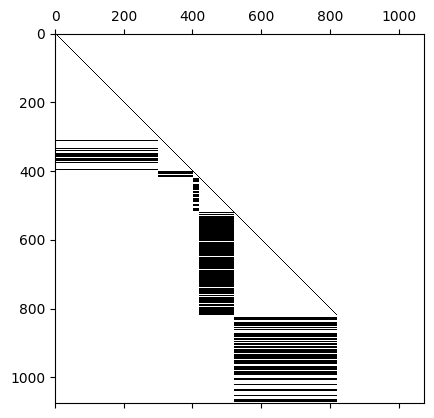

In [24]:
# Jacobian for Z-step
plt.spy(J)
plt.show()

Trained model reconstruction results:


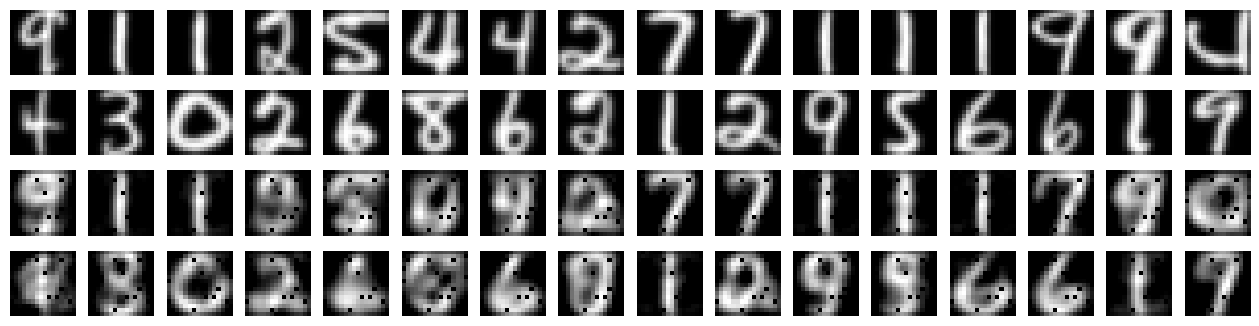

In [25]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Trained model reconstruction results:')
    plot_progress(x, z)
    
    break

In [26]:
print(f'Eval loss: {eval_loss(model, test_loader, loss_function, device=device)}')

Eval loss: 0.03536323085427284


# Hybrid Approach

## on cpu, randomly initialized z

In [36]:
%%time

relu = nn.ReLU()
line_search_c = pow(10,-4)
# backtracking multiplier
line_search_tau = 0.5
alphas_w = []
alphas_z = []
loss_hist = []

# registering hooks to cache activations
model = AE().to(device)

WEIGHTS = [
    model.encoder[0].weight.detach().cpu(),
    model.encoder[2].weight.detach().cpu(),
    model.encoder[4].weight.detach().cpu(),
    model.decoder[0].weight.detach().cpu(),
    model.decoder[2].weight.detach().cpu(),
    model.decoder[4].weight.detach().cpu(),
]

# sum of all output shapes
H = 0
h_k = [0]
for W in WEIGHTS:
    H += W.shape[0]
    h_k.append(W.shape[0] + h_k[-1])
h_k = h_k[1:]

CACHE_RELUS = {}
for i in range(len(WEIGHTS)):
    CACHE_RELUS[i] = torch.rand((7291, WEIGHTS[i].shape[0])) - 0.5
    CACHE_RELUS[i] = torch.where(CACHE_RELUS[i] > 0, CACHE_RELUS[i], torch.tensor(0, dtype=torch.float))
    
    
for x, _ in train_loader:
    x = x.cpu()
    
with torch.no_grad():
    for epoch in range(10):
        
        # W-Step
        WEIGHTS_COPY = copy.deepcopy(WEIGHTS)

        for layer_idx in tqdm(range(len(CACHE_RELUS))):
            in_dim = WEIGHTS[layer_idx].shape[1]
            out_dim = WEIGHTS[layer_idx].shape[0]
            n_samples = CACHE_RELUS[layer_idx].shape[0]

            if layer_idx == 0:
                residuals = CACHE_RELUS[layer_idx] - relu(x @ WEIGHTS[layer_idx].T)
            elif layer_idx == len(CACHE_RELUS) - 1:
                # reconstruction task
                residuals = x - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            else:
                residuals = CACHE_RELUS[layer_idx] - relu(CACHE_RELUS[layer_idx-1] @ WEIGHTS[layer_idx].T)
            # print('residuals:', residuals.shape)

            for h in range(out_dim):
                # Building Jacobian (for each layer and output dim)
                J = torch.zeros((n_samples, in_dim))
                w = WEIGHTS[layer_idx][h]

                if layer_idx == 0:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - x[n]
                else:
                    for n in range(n_samples):
                        if CACHE_RELUS[layer_idx][n][h] > 0:
                            J[n, :] = - CACHE_RELUS[layer_idx-1][n]

                p = torch.linalg.lstsq(J.T@J, - J.T @ residuals[:, h])[0]
                # print('shape of p:', p.shape, 'shape of w:', w.shape)
                # p.T @ grad (.T doesn't matter, numpy performs inner product)
                descent_inner_prod = (J.T @ residuals[:, h]) @ p
                try:
                    assert descent_inner_prod <= 0
                except:
                    pass
                    # print(f'layer {layer_idx+1} dim {h} descent(should be <= 0)', descent_inner_prod)

                # Line Search with Backtracking
                alpha = 1.0
                fw = (residuals[:,h]**2).sum() / 2
                # First Update
                w += alpha*p
                if layer_idx == 0:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new = x[:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                else:
                    residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                max_iter, counter = 20, 0
                # Armijo Condition
                while fw_new - fw > rhs and counter < max_iter:
                    alpha *= line_search_tau
                    # Update
                    w = WEIGHTS_COPY[layer_idx][h] + alpha * p
                    if layer_idx == 0:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', x, w))
                    else:
                        residuals_new = CACHE_RELUS[layer_idx][:,h] - relu(torch.einsum('bq,q->b', CACHE_RELUS[layer_idx-1], w))
                    fw_new = (residuals_new**2).sum() / 2
                    rhs = alpha * line_search_c * descent_inner_prod

                    # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                    counter += 1
                # alphas_w.append(alpha)

        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx}, '
                  f'Weights Diff Norm: {torch.norm(WEIGHTS[layer_idx]-WEIGHTS_COPY[layer_idx])}')
        model.encoder[0].weight.data = WEIGHTS[0]
        model.encoder[2].weight.data = WEIGHTS[1]
        model.encoder[4].weight.data = WEIGHTS[2]
        model.decoder[0].weight.data = WEIGHTS[3]
        model.decoder[2].weight.data = WEIGHTS[4]
        model.decoder[4].weight.data = WEIGHTS[5]
        model = model.to(device)
        
        # Loss on eval dataset
        loss = eval_loss(model, test_loader, loss_function, device=device)
        loss_hist.append(loss)
        print(f'Epoch {epoch+1}, Eval loss: {loss}')  

        # Z-Step
        CACHE_RELUS_COPY = copy.deepcopy(CACHE_RELUS)
            
        for n_sample in tqdm(range(len(x))):

            # Calculating Residuals
            residuals = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]

            # Building Jacobian for each sample in dataset
            J = torch.zeros((H, H))
            for h in range(H):
                if h < h_k[-2]: J[h, h] = 1
                for layer_idx in range(len(h_k)):
                    if h <= h_k[layer_idx]: break
                if layer_idx == 0: continue

                n_feature = h-h_k[layer_idx-1]-1
                assert n_feature >= 0 and n_feature < WEIGHTS[layer_idx].shape[0]

                if layer_idx == 1:
                    start, finish = 0, h_k[layer_idx-1]
                elif layer_idx > 1:
                    start, finish = h_k[layer_idx-2], h_k[layer_idx-1]
                # print(CACHE_RELUS[layer_idx][n_sample][n_feature])
                if CACHE_RELUS[layer_idx][n_sample][n_feature] > 0:
                    # print(start, finish, n_feature, WEIGHTS[layer_idx][n_feature].shape)
                    J[h, start:finish] = - WEIGHTS[layer_idx][n_feature]

            # Descent Direction
            p = torch.linalg.lstsq(J.T@J, - J.T @ residuals)[0]
            # print('shape of p:', p.shape, 'shape of w:', w.shape)
            # p.T @ grad (.T doesn't matter, numpy performs inner product)
            descent_inner_prod = (J.T @ residuals) @ p
            try:
                assert descent_inner_prod <= 0
            except:
                print(f'sample {n_sample} descent direction should be <= 0', descent_inner_prod)

            # Line Search with Backtracking
            alpha = 1.0
            fw = residuals.sum() / 2
            # update
            for layer_idx in range(len(CACHE_RELUS)):
                if layer_idx == 0:
                    start, finish = 0, h_k[layer_idx]
                else:
                    start, finish = h_k[layer_idx-1], h_k[layer_idx]

                CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                
            residuals_new = torch.zeros(H)
            start = 0
            for layer_idx in range(len(h_k)):
                if layer_idx == 0:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                elif layer_idx == len(CACHE_RELUS) - 1:
                    residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                else:
                    residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                start = h_k[layer_idx]
            fw_new = (residuals_new**2).sum() / 2
            rhs = alpha * line_search_c * descent_inner_prod
            # print('fw:', fw, fw_new, rhs)
            

            max_iter, counter = 40, 0
            # Armijo Condition
            while fw_new - fw > rhs and counter < max_iter:
                # step update
                alpha *= line_search_tau
                
                # relus update
                for layer_idx in range(len(CACHE_RELUS)):
                    if layer_idx == 0:
                        start, finish = 0, h_k[layer_idx]
                    else:
                        start, finish = h_k[layer_idx-1], h_k[layer_idx]

                    CACHE_RELUS[layer_idx][n_sample] = CACHE_RELUS_COPY[layer_idx][n_sample] + alpha * p[start:finish]
                    
                # recompute residuals
                start = 0
                for layer_idx in range(len(h_k)):
                    if layer_idx == 0:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', x[n_sample], WEIGHTS[layer_idx]))
                    elif layer_idx == len(CACHE_RELUS) - 1:
                        residuals_new[start:h_k[layer_idx]] = x[n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    else:
                        residuals_new[start:h_k[layer_idx]] = CACHE_RELUS[layer_idx][n_sample] - relu(torch.einsum('q,hq->h', CACHE_RELUS[layer_idx-1][n_sample], WEIGHTS[layer_idx]))
                    start = h_k[layer_idx]
                fw_new = (residuals_new**2).sum() / 2
                rhs = alpha * line_search_c * descent_inner_prod

                # print("Line search armijo: obj func old: %f new: %f diff: %.16f rhs: %.16f, alpha: %f" % (fw, fw_new, fw_new - fw, rhs, alpha))
                counter += 1
        
        for layer_idx in range(len(CACHE_RELUS)):
            print(f'Layer {layer_idx} Activations Diff Norm: '
                  f'{torch.linalg.norm(CACHE_RELUS[layer_idx]-CACHE_RELUS_COPY[layer_idx])}')
        # print()

100%|██████████| 6/6 [01:55<00:00, 19.19s/it]


Layer 0, Weights Diff Norm: 1.9857531785964966
Layer 1, Weights Diff Norm: 4.272276401519775
Layer 2, Weights Diff Norm: 1.7131935358047485
Layer 3, Weights Diff Norm: 4.584957122802734
Layer 4, Weights Diff Norm: 6.684366703033447
Layer 5, Weights Diff Norm: 9.431990623474121


100%|██████████| 7291/7291 [08:45<00:00, 13.87it/s]

Layer 0 Activations Diff Norm: 2.4092583656311035
Layer 1 Activations Diff Norm: 1.273698329925537
Layer 2 Activations Diff Norm: 0.44054824113845825
Layer 3 Activations Diff Norm: 1.239688515663147
Layer 4 Activations Diff Norm: 2.919961929321289
Layer 5 Activations Diff Norm: 0.0


Epoch 1, Eval loss: 3.075035333633423


100%|██████████| 6/6 [02:15<00:00, 22.51s/it]


Layer 0, Weights Diff Norm: 1.6010977029800415
Layer 1, Weights Diff Norm: 4.123340129852295
Layer 2, Weights Diff Norm: 1.7353394031524658
Layer 3, Weights Diff Norm: 3.949164390563965
Layer 4, Weights Diff Norm: 6.40809965133667
Layer 5, Weights Diff Norm: 4.457452774047852


100%|██████████| 7291/7291 [08:50<00:00, 13.74it/s]

Layer 0 Activations Diff Norm: 59.04127883911133
Layer 1 Activations Diff Norm: 30.70993995666504
Layer 2 Activations Diff Norm: 13.354096412658691
Layer 3 Activations Diff Norm: 30.287578582763672
Layer 4 Activations Diff Norm: 61.8311767578125
Layer 5 Activations Diff Norm: 0.0


Epoch 2, Eval loss: 0.10059569031000137


100%|██████████| 6/6 [02:17<00:00, 22.92s/it]


Layer 0, Weights Diff Norm: 0.6709943413734436
Layer 1, Weights Diff Norm: 0.8611099123954773
Layer 2, Weights Diff Norm: 0.3143318295478821
Layer 3, Weights Diff Norm: 0.4591161906719208
Layer 4, Weights Diff Norm: 0.8600250482559204
Layer 5, Weights Diff Norm: 3.4994559288024902


100%|██████████| 7291/7291 [08:55<00:00, 13.61it/s]

Layer 0 Activations Diff Norm: 38.55351638793945
Layer 1 Activations Diff Norm: 20.394229888916016
Layer 2 Activations Diff Norm: 8.734639167785645
Layer 3 Activations Diff Norm: 20.168073654174805
Layer 4 Activations Diff Norm: 39.48279571533203
Layer 5 Activations Diff Norm: 0.0


Epoch 3, Eval loss: 0.07234560698270798


100%|██████████| 6/6 [02:18<00:00, 23.10s/it]


Layer 0, Weights Diff Norm: 0.4364675283432007
Layer 1, Weights Diff Norm: 0.5344045758247375
Layer 2, Weights Diff Norm: 0.17208881676197052
Layer 3, Weights Diff Norm: 0.19670456647872925
Layer 4, Weights Diff Norm: 0.5762251615524292
Layer 5, Weights Diff Norm: 1.9962300062179565


100%|██████████| 7291/7291 [08:59<00:00, 13.52it/s]

Layer 0 Activations Diff Norm: 31.028291702270508
Layer 1 Activations Diff Norm: 16.192440032958984
Layer 2 Activations Diff Norm: 7.119800090789795
Layer 3 Activations Diff Norm: 15.980497360229492
Layer 4 Activations Diff Norm: 31.094043731689453
Layer 5 Activations Diff Norm: 0.0


Epoch 4, Eval loss: 0.06666052341461182


100%|██████████| 6/6 [02:19<00:00, 23.18s/it]


Layer 0, Weights Diff Norm: 0.2953003942966461
Layer 1, Weights Diff Norm: 0.409574955701828
Layer 2, Weights Diff Norm: 0.1245778426527977
Layer 3, Weights Diff Norm: 0.12264195084571838
Layer 4, Weights Diff Norm: 0.4631118178367615
Layer 5, Weights Diff Norm: 1.4716778993606567


100%|██████████| 7291/7291 [09:00<00:00, 13.49it/s]

Layer 0 Activations Diff Norm: 25.20844268798828
Layer 1 Activations Diff Norm: 13.380949020385742
Layer 2 Activations Diff Norm: 5.797760486602783
Layer 3 Activations Diff Norm: 13.074374198913574
Layer 4 Activations Diff Norm: 25.269027709960938
Layer 5 Activations Diff Norm: 0.0


Epoch 5, Eval loss: 0.06511352211236954


100%|██████████| 6/6 [02:19<00:00, 23.20s/it]


Layer 0, Weights Diff Norm: 0.33261722326278687
Layer 1, Weights Diff Norm: 0.3377106785774231
Layer 2, Weights Diff Norm: 0.10139844566583633
Layer 3, Weights Diff Norm: 0.10237664729356766
Layer 4, Weights Diff Norm: 0.3897330164909363
Layer 5, Weights Diff Norm: 1.1693693399429321


100%|██████████| 7291/7291 [08:59<00:00, 13.51it/s]

Layer 0 Activations Diff Norm: 21.727479934692383
Layer 1 Activations Diff Norm: 11.509986877441406
Layer 2 Activations Diff Norm: 4.865500450134277
Layer 3 Activations Diff Norm: 11.40498161315918
Layer 4 Activations Diff Norm: 21.882238388061523
Layer 5 Activations Diff Norm: 0.0


Epoch 6, Eval loss: 0.06460635364055634


100%|██████████| 6/6 [02:19<00:00, 23.22s/it]


Layer 0, Weights Diff Norm: 0.2342369556427002
Layer 1, Weights Diff Norm: 0.291537344455719
Layer 2, Weights Diff Norm: 0.08827684074640274
Layer 3, Weights Diff Norm: 0.08675645291805267
Layer 4, Weights Diff Norm: 0.3472529351711273
Layer 5, Weights Diff Norm: 1.0034995079040527


100%|██████████| 7291/7291 [09:01<00:00, 13.47it/s]

Layer 0 Activations Diff Norm: 17.148019790649414
Layer 1 Activations Diff Norm: 9.005594253540039
Layer 2 Activations Diff Norm: 3.8608078956604004
Layer 3 Activations Diff Norm: 8.886577606201172
Layer 4 Activations Diff Norm: 17.04497528076172
Layer 5 Activations Diff Norm: 0.0


Epoch 7, Eval loss: 0.06434471160173416


100%|██████████| 6/6 [02:19<00:00, 23.26s/it]


Layer 0, Weights Diff Norm: 0.2294185906648636
Layer 1, Weights Diff Norm: 0.2386171519756317
Layer 2, Weights Diff Norm: 0.07051056623458862
Layer 3, Weights Diff Norm: 0.07164283096790314
Layer 4, Weights Diff Norm: 0.29346388578414917
Layer 5, Weights Diff Norm: 0.7551040053367615


100%|██████████| 7291/7291 [08:59<00:00, 13.50it/s]

Layer 0 Activations Diff Norm: 15.221259117126465
Layer 1 Activations Diff Norm: 8.023037910461426
Layer 2 Activations Diff Norm: 3.3226797580718994
Layer 3 Activations Diff Norm: 8.031200408935547
Layer 4 Activations Diff Norm: 15.491219520568848
Layer 5 Activations Diff Norm: 0.0


Epoch 8, Eval loss: 0.06421123445034027


100%|██████████| 6/6 [02:19<00:00, 23.29s/it]


Layer 0, Weights Diff Norm: 0.13525594770908356
Layer 1, Weights Diff Norm: 0.21217556297779083
Layer 2, Weights Diff Norm: 0.06517895311117172
Layer 3, Weights Diff Norm: 0.062353722751140594
Layer 4, Weights Diff Norm: 0.26825976371765137
Layer 5, Weights Diff Norm: 0.6720612645149231


100%|██████████| 7291/7291 [09:03<00:00, 13.41it/s]

Layer 0 Activations Diff Norm: 14.722282409667969
Layer 1 Activations Diff Norm: 7.558471202850342
Layer 2 Activations Diff Norm: 3.2546355724334717
Layer 3 Activations Diff Norm: 7.539060592651367
Layer 4 Activations Diff Norm: 14.333359718322754
Layer 5 Activations Diff Norm: 0.0


Epoch 9, Eval loss: 0.06415475904941559


100%|██████████| 6/6 [02:19<00:00, 23.28s/it]


Layer 0, Weights Diff Norm: 0.30403879284858704
Layer 1, Weights Diff Norm: 0.20080731809139252
Layer 2, Weights Diff Norm: 0.058815762400627136
Layer 3, Weights Diff Norm: 0.059722620993852615
Layer 4, Weights Diff Norm: 0.2541356086730957
Layer 5, Weights Diff Norm: 0.6225025057792664


100%|██████████| 7291/7291 [09:02<00:00, 13.44it/s]

Layer 0 Activations Diff Norm: 11.585919380187988
Layer 1 Activations Diff Norm: 6.425036430358887
Layer 2 Activations Diff Norm: 2.802086591720581
Layer 3 Activations Diff Norm: 6.227432727813721
Layer 4 Activations Diff Norm: 11.561108589172363
Layer 5 Activations Diff Norm: 0.0


Epoch 10, Eval loss: 0.06416246294975281
CPU times: user 5h 34min 13s, sys: 33.8 s, total: 5h 34min 47s
Wall time: 1h 52min 34s


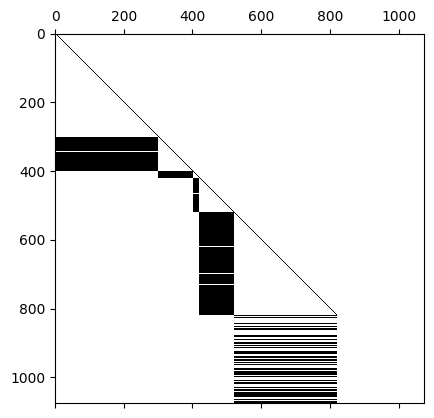

In [37]:
# Jacobian for Z-step
plt.spy(J)
plt.show()

Trained model reconstruction results:


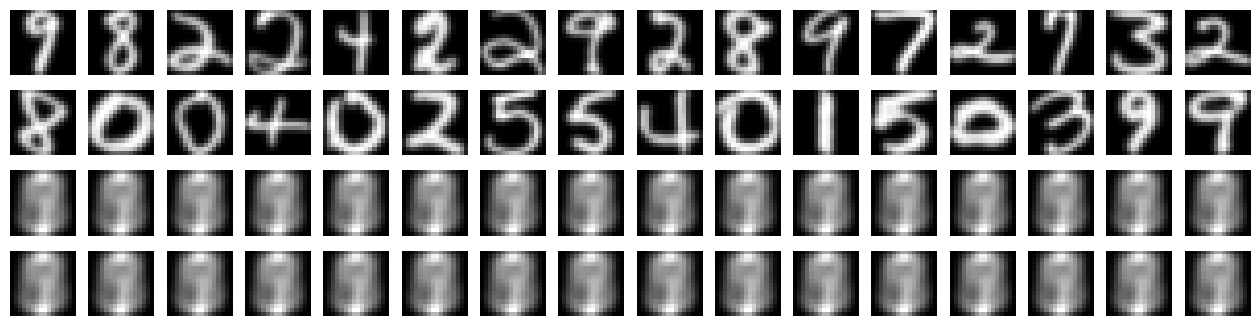

In [39]:
for x, _ in train_loader:
    x = x[:32].to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Trained model reconstruction results:')
    plot_progress(x, z)
    
    break